# Large language models (LLMs)
are advanced AI-based models trained to process and generate human language in a way that closely mirrors natural human communication. These models leverage deep learning techniques and vast amounts of training data to develop a thorough understanding of language structures, grammar, context, and semantics. Such renowned models like GPT-3, GPT-4, LaMDA, BLOOM, LLaMA

# Fine tuning LLM
Fine-tuning a large language model (LLM) refers to the process of further training a pre-trained model on a specialized dataset or task. This helps the model adapt to specific use cases, improving its performance on tasks like text classification, translation, or summarization, by refining its knowledge on the new data while leveraging its existing general language understanding.


# Summarization Task
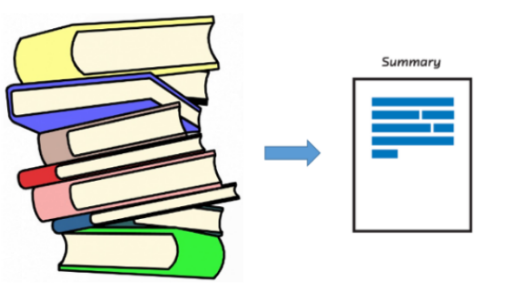

Summarization creates a shorter version of a document or an article that captures all the important information. Along with translation, it is another example of a task that can be formulated as a sequence-to-sequence task. Summarization can be:
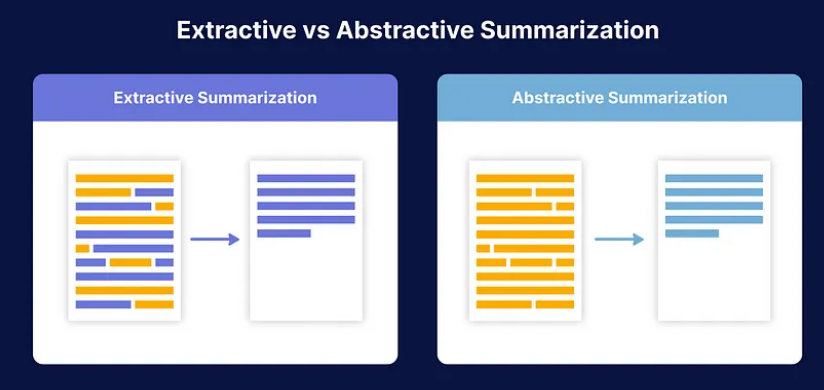
1. Extractive: extract the most relevant information from a document.
2. Abstractive: generate new text that captures the most relevant information.


# we are going to perform abstractive summarization.
#### 1. Using T5 model from Google from Hugging face Transformer Library  : https://huggingface.co/google-t5/t5-small
#### 2. Data set USed : California state bill subset of the BillSum dataset :https://huggingface.co/datasets/FiscalNote/billsum/viewer/default/ca_test?row=0
#### 3. Use finetuned model for inference and Compare with Non finetuned T5 model.

In [ ]:
!pip install transformers datasets evaluate rouge_score


# Loading Dataset

In [ ]:
from datasets import load_dataset

billsum = load_dataset("billsum", split="ca_test")
#load only the "ca_test" split of the dataset.

In [ ]:
billsum

In [ ]:
billsum = billsum.train_test_split(test_size=0.2)

In [ ]:
billsum

In [ ]:
billsum['train'][0]

# There are two fields that we are going to use:

#### text: the text of the bill which’ll be the input to the model.
#### summary: a condensed version of text which’ll be the model target.

# loading a T5 model to process text and summary

In [ ]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

#### - Prefix the input with a prompt so T5 knows this is a summarization task. 
#### - Use the keyword text_target argument when tokenizing labels.
#### - Truncate sequences to be no longer than the maximum length set by the max_length parameter.

In [ ]:
#Now To apply the preprocessing function over the entire dataset, 
#use Datasets map method and speed up the map function by setting batched=True to process multiple elements of the dataset at once.
tokenized_billsum = billsum.map(preprocess_function, batched=True)

Now create a batch of examples using DataCollatorForSeq2Seq. It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

# Evaluate
helpful for evaluating your model’s performance.
going to use rough metrix here for text summarization

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

In [ ]:
import numpy as np

# function that passes predictions and labels to compute to calculate the ROUGE metric:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
#checkpoint = "google-t5/t5-small" already taken before
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

# NON -finetuned Model Summary

In [ ]:
# Define the input text
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

# Tokenize the input text
input_ids = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True)

# Generate summary
summary_ids = model.generate(input_ids, max_length=50, num_beams=2, length_penalty=2.0, early_stopping=True)

# Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print the summary
print(summary)

# NOW Three steps remain:

#### 1. Defining training hyperparameters in Seq2SeqTrainingArguments. The only required parameter is output_dir which specifies where to save our model.we can push this model to the Hub by setting push_to_hub=True. At the end of each epoch, the Trainer will evaluate the ROUGE metric and save the training checkpoint.
#### 2. Passing the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.
#### 3. Call train() to finetune your model.

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
# Move model to the selected device
model.to(device)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="pandey_finetune_model",
    eval_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True, #change to bf16=True for XPU
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_billsum["train"],
    eval_dataset=tokenized_billsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# Inferencing/predicting the Model After Finetuning

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the trained model and tokenizer from the local directory
model_dir = "/kaggle/working/pandey_finetune_model/checkpoint-2480"
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Define your input text for inference
input_text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

# Tokenize the input text
input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids

# Generate the output (summary, translation, etc.)
output_ids = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)

# Decode the generated output
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print the result
print("Summary:", output_text)


# Challenges faced during this
#### 1.Slow training
#### 2.out of memory error


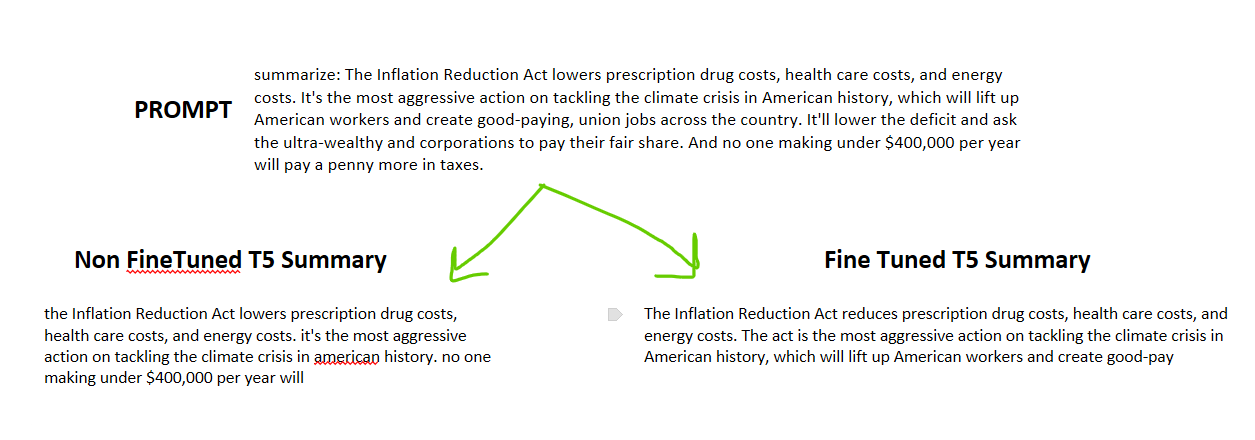

# Parameter-efficient fine-tuning
Training a language model is a computationally intensive task. For a full LLM fine-tuning, you need memory not only to store the model, but also the parameters that are necessary for the training process.PEFT updates only a small subset of model parameters, reducing memory and computational requirements. Techniques like LoRA can reduce trainable parameters by up to 10,000 times compared to full LLM fine-tuning.

Fine Tuning Using PEFT-loRA for Text Classification in IMDB Dataset is in This Note book :- https://www.kaggle.com/code/ankitpandey1576/fine-tuning-the-llm-model/

